In [1]:
from chromatic import *
import pickle

Let's load in Patricio's file of injected signals.

In [2]:
x = pickle.load(open('data_challenge_spectra_v01.pickle', 'rb'))
x.keys()

dict_keys(['units', 'NGTS10b_parameters', 'WASP39b_parameters', 'NGTS10b_MIRI', 'WASP39b_NIRCam', 'WASP39b_NIRSpec', 'WASP39b_NIRISS'])

In [3]:
x['units']

{'emission': 'Fp/Fs',
 'transmission': '(Rp/Rs)**2',
 'stellar_flux': 'erg s-1 cm-2 cm',
 'wl': 'microns',
 'LDC': 'C1, C2, C3, C4',
 'period': 'days',
 'T14': 'orbital phase',
 'rstar': 'cm'}

Let's look at the basic planet parameters.

In [4]:
x['NGTS10b_parameters']

{'rprs': 0.1784,
 'cosi': 0.184,
 'a_rs': 4.447,
 'period': 0.7668944,
 'rstar': 48490290000.0,
 'eclipse_T14': 0.06214674172045835,
 'eclipse_T12': 0.005399290514000121,
 'LDC_miri': [0.0, -0.08922, 0.0, 0.9462]}

In [5]:
x['WASP39b_parameters']

{'cosi': 0.03786459100977565,
 'a_rs': 11.37,
 'period': 4.055259,
 'rstar': 62265150000.0,
 'LDC_niriss1': [0.0, 0.7373, 0.0, -0.2928],
 'LDC_niriss2': [0.0, 0.8253, 0.0, -0.2624],
 'LDC_nirspec': [0.0, 0.2379, 0.0, 0.4615],
 'LDC_nircam': [0.0, 0.2379, 0.0, 0.4615]}

Now, what's included for each instrument?

In [6]:
def summarize_instrument(d):
    for x in d:
        print(f'{x} = {np.shape(d[x])}')

In [7]:
summarize_instrument(x['NGTS10b_MIRI'])

emission_day = (322,)
emission_night = (322,)
transmission = (322,)
stellar_flux = (322,)
wl = (322,)


In [8]:
summarize_instrument(x['WASP39b_NIRCam'])

transmission = (2049,)
stellar_flux = (2049,)
wl = (2049,)


In [9]:
summarize_instrument(x['WASP39b_NIRSpec'])

transmission = (500,)
stellar_flux = (500,)
wl = (500,)


In [10]:
summarize_instrument(x['WASP39b_NIRISS'])

transmission1 = (2048,)
transmission2 = (1838,)
stellar_flux1 = (2048,)
stellar_flux2 = (1838,)
wl1 = (2048,)
wl2 = (1838,)


At this point, we could probably directly start making some plots with the models, compared to data. However, for thinking about the future, it'd be nice to define some objects to collect handy tools.

In [94]:
class PlanetarySpectrum:
    @property
    def wavelength(self):
        return self.table['wavelength'].quantity

    @property
    def depth(self):
        return self.table['depth'].quantity

    @property
    def uncertainty(self):
        return self.table['uncertainty'].quantity
    
    def __init__(self, table=None, label=None):
        '''
        Initialize planetary spectrum object.

        Parameters
        ----------
        table : astropy.table.Table
            A table of depths (or other wavelength-dependent features).
            It should contain at least:
                + `wavelength` should represent the central wavelength of the 
                   wavelength bin. Alternatively, there could be two columns 
                   labeled `wavelength_lower` and `wavelength_upper` to represent 
                   the lower and upper bounds of each wavelength bin. The units 
                   should be in microns.
                + `depth` should be the transit depth $(R_p/R_\star)^2$ or the 
                   eclipse depth ($F_p/F_\star$). This quantity should be unitless; 
                   for example, a transit depth of 1% should be written as `0.01`.
                + `uncertainty` should be the uncertainty on the depth (if this 
                   is data). This quantity should have the same units as depth 
                   (so also be unitless).
             Planet parameters can/should be included as `meta` in this 
             initializing astropy table.
         label : str
             A string labeling this planet spectrum. It might appear in the 
             the display name for the object, plot legends, filenames, ...             
         '''

        # store the original data inputs
        self.table = Table(table)

        # store additional information that might be handy
        self.label = label        
        
        # make sure the data format works
        self._validate_data()


    def _validate_data(self):
        '''
        Make sure the data table has the right format.
        '''
        
        # validate each core component
        self._validate_wavelengths()
        self._validate_depths()
        self._validate_uncertainties()
        
    def _validate_wavelengths(self):
        '''
        Make sure wavelengths are usable.
        '''
            
        # set centers from edges, if necessary
        if "wavelength" not in self.table.columns:
            self.table["wavelength"] = 0.5 * (self.table["wavelength_lower"] + self.table["wavelength_upper"])

        # set edges from centers, if necessary
        if ("wavelength_lower" not in self.table.columns) and ("wavelength_upper" not in self.table.columns):
            bin_widths = np.gradient(self.table["wavelength"])
            self.table["wavelength_lower"] = self.table["wavelength"] - bin_widths / 2
            self.table["wavelength_upper"] = self.table["wavelength"] + bin_widths / 2    

        # make sure the units are good
        for k in ['wavelength', 'wavelength_lower', 'wavelength_upper']:
            try:
                self.table[k] = self.table[k].to(u.micron)
                print(f'units worked for {k}')
            except (AttributeError, u.UnitConversionError):
                self.table[k] = self.table[k]*u.micron
                print(f'units needed to be fudged for {k}')
                warnings.warn(f'🌈 Assuming units for {k} are micron.')
                    
        assert('wavelength' in self.table.columns)

    def _validate_depths(self):
        '''
        Make sure depths are usable.
        '''        
        if np.all(depth > 1):
            messages = '''
            🪐 All depths are >1, implying the planet is 
            bigger than the star. Depths, should be unitless,
            so a 1% transit should have a depth of 0.01.
            '''
            warnings.warn(message)
  
    def _validate_uncertainties(self):
        '''
        Make sure uncertainties are usable.
        '''        
        pass
            
    def __repr__(self):
        if 'uncertainty' in self.table.columns:
            extra = ' with uncertainties!'
        else:
            extra = ''
        return f'<🪐PlanetarySpectrum({len(self.wavelength)}w{extra})>'


In [95]:
class PlanetarySpectrumModel(PlanetarySpectrum):
    
    def plot(self, ax=None, **kw):
        '''
        Plot the model.
        
        Parameters
        ----------
        ax : matplotlib.axes._subplots.AxesSubplot
            The axes into which the plot should be drawn.
        kw : dict
            Extra keywords will be passed along to `plt.plot`
        '''
        if ax is None:
            plt.figure(figsize=(8, 6), dpi=300)
            ax = plt.gca()
        else:
            plt.sca(ax)
            
        plot_kw = dict(alpha=0.5, linewidth=2, label=self.label)
        plot_kw.update(**kw)
        plt.plot(self.table['wavelength'], self.table['depth'], **plot_kw)
        plt.xlabel("Wavelength (micron)")
        plt.ylabel("Depth (unitless)")
        return ax

In [96]:
class PlanetarySpectrumData(PlanetarySpectrum):
    
    def plot(self, ax=None, **kw):
        """
        Plot some planetary features.

        Parameters
        ----------
        ax : matplotlib.axes._subplots.AxesSubplot
            The axes into which the plot should be drawn.
        """
#         table = Table(self)

        lower = self.table["wavelength"] - self.table["wavelength_lower"]
        upper = self.table["wavelength_upper"] - self.table["wavelength"]

        errorkw = dict(marker="o", linewidth=0, elinewidth=1, label=self.label)
        errorkw.update(**kw)

        if ax is None:
            plt.figure(figsize=(8, 6), dpi=300)
            ax = plt.gca()
        else:
            plt.sca(ax)
        plt.errorbar(
            self.table["wavelength"],
            self.table["depth"],
            yerr=self.table["uncertainty"],
            xerr=[lower, upper],
            **errorkw,
        )
        plt.xlabel("Wavelength (micron)")
        plt.ylabel("Depth (unitless)")
        return ax

In [14]:
# lets load a model
planet = x['WASP39b_NIRSpec']
planet_params = x['WASP39b_parameters']

wavelength = planet['wl']
depth = planet['transmission']
table = Table(dict(wavelength=planet['wl'], depth=planet['transmission']), meta=planet_params)

model = PlanetarySpectrumModel(table=table, label='injected model')

units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper



🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.

In [15]:
from utils import load_feature_file, write_example_file

write_example_file('some-test-features.txt')
table = load_feature_file('some-test-features.txt')
data = PlanetarySpectrumData(table, label='some nonsense data')

units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper



🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.

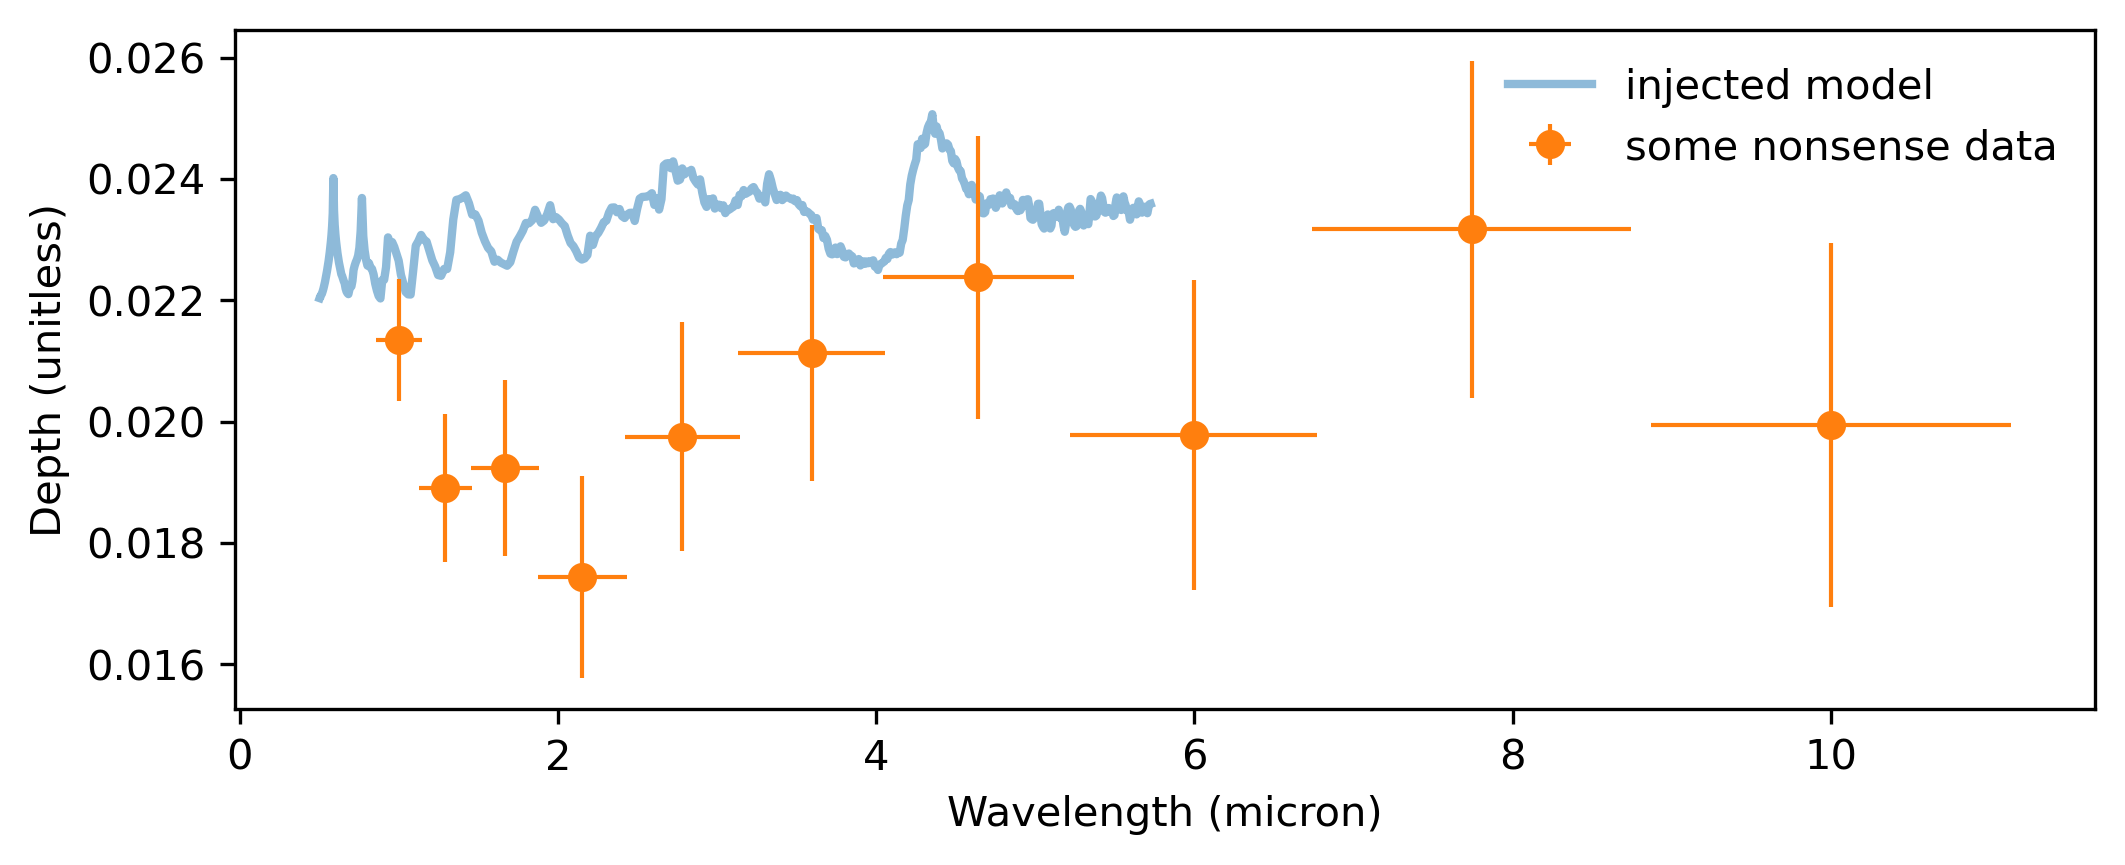

In [16]:
ax = model.plot()
data.plot(ax=ax)
plt.legend(frameon=False);

## Import user-submitted data for Data Challenge

In [122]:
from astropy.io import ascii
from astropy.table import Table
import glob

In [126]:
def standardise_table_format(dtable):
    # module to standardize the astropy table format (a bit hacky at the moment)
    colnames = submitted_data.colnames
    
    if 'wavelength' not in colnames:
        submitted_data.rename_column(colnames[0], 'wavelength')
    
    if 'depth (ppt)' in colnames:
        submitted_data.rename_column('depth (ppt)', 'depth')
        submitted_data['depth'] = submitted_data['depth']/1000
    elif 'depth' not in colnames:
        submitted_data.rename_column(colnames[1], 'depth')
    
    if 'depth err (ppt)' in colnames:
        submitted_data.rename_column("depth err (ppt)", 'uncertainty')
        submitted_data['uncertainty'] = submitted_data['uncertainty']/1000
    elif 'uncertainty' not in colnames:
        submitted_data.rename_column(colnames[2], 'uncertainty')
    
    return submitted_data

In [127]:
# import all the participant data
all_dfiles = glob.glob("participant_data/*")
print("List of Submitted Files:\n","\n".join([d.split("/")[-1] for d in all_dfiles]))

List of Submitted Files:
 NIRCam_transmission_spectrum_GP_2kernels.txt
Murray_NIRCam_transmission3.txt
NIRCam_transmission_spectrum_noGP.txt
Stevenson-NIRCam-Astro-S6.txt
spec_astroph.csv
ERS_Astrophysical_TransSpectrum.txt
NIRCam_transmission_spectrum_GP.txt


units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper
units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper
units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper
units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper
units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper
units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper
units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper



🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.
🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.
🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.
🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.
🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.
🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron

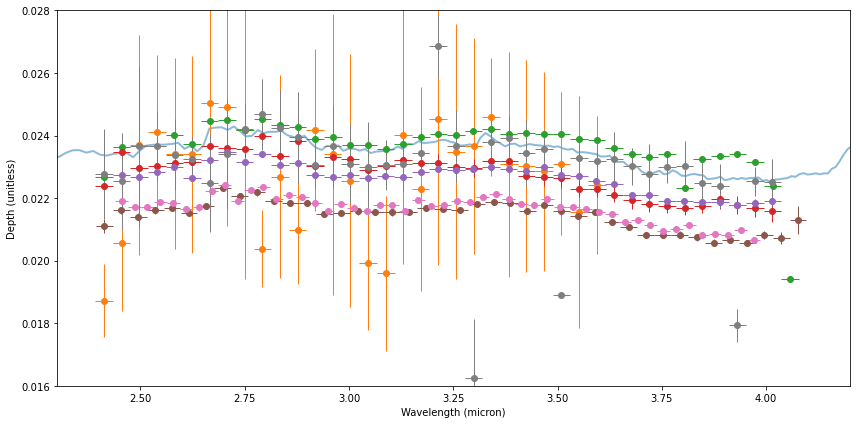

In [128]:
fig,ax = plt.subplots(figsize=(12,6))

# plot the model underneath all the user-submitted data
ax = model.plot(ax)

for d in all_dfiles:
    
    # import each of the data files
    submitted_data = ascii.read(d)
    
    # format the columns + column names into the correct format:
    formatted_data = standardise_table_format(submitted_data)
    
    # create a Planetary Spectrum object:
    data = PlanetarySpectrumData(formatted_data, label=d.split("/")[-1])
    
    # plot each user's data
    data.plot(ax=ax)
    
plt.xlim(2.3,4.2)
plt.ylim(0.016,0.028)
# plt.legend(frameon=True,bbox_to_anchor=(1.08, 0.6))
plt.tight_layout();